In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns   
from scipy.signal import butter, filtfilt
# import seglearn as sglearn        # For windowing and sequence modeling
import tsfresh     
import os
from sklearn.preprocessing import StandardScaler

 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import polars as pl
import dask.dataframe as dd
from pathlib import Path

# Data Exploration

In [3]:
# File paths for three training datasets
defog = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog')
notype = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype')
tdcsfog = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog')

In [4]:
defog_files = [f for f in os.listdir(defog) if f.endswith('.csv')]

# List to store individual DataFrames
defog_list = []

for path in defog.glob("*.csv"):
    patient_id = path.stem  # removes .csv

    df = pl.read_csv(path)
    df = df.with_columns([
        pl.lit(patient_id).alias("patient_id")
    ])
    
    defog_list.append(df)

defog_df = pl.concat(defog_list)
# for f in defog_files:
#     file_path = os.path.join(defog, f)
#     df = pl.read_csv(file_path)
#     df = df.with_columns([
#         pl.lit(f).alias('file')  # Add filename as identifier
#     ])
#     defog_list.append(df)

# # Concatenate into one large DataFrame
# defog_df = pl.concat(defog_list)

In [5]:
defog_df.head()

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,patient_id
i64,f64,f64,f64,i64,i64,i64,bool,bool,str
0,-1.002697,0.022371,0.068304,0,0,0,false,false,"""be9d33541d"""
1,-1.002641,0.019173,0.066162,0,0,0,false,false,"""be9d33541d"""
2,-0.99982,0.019142,0.067536,0,0,0,false,false,"""be9d33541d"""
3,-0.998023,0.018378,0.068409,0,0,0,false,false,"""be9d33541d"""
4,-0.998359,0.016726,0.066448,0,0,0,false,false,"""be9d33541d"""


Load dataset

In [6]:
notype_files = [f for f in os.listdir(notype) if f.endswith('.csv')]

# List to store individual DataFrames
notype_list = []

for path in notype.glob("*.csv"):
    patient_id = path.stem  # removes .csv

    df = pl.read_csv(path)
    df = df.with_columns([
        pl.lit(patient_id).alias("patient_id")
    ])
    
    notype_list.append(df)

notype_df = pl.concat(notype_list)

In [7]:
notype_df.head()

Time,AccV,AccML,AccAP,Event,Valid,Task,patient_id
i64,f64,f64,f64,i64,bool,bool,str
0,-0.991926,-0.119916,0.050087,0,false,false,"""1e8d55d48d"""
1,-0.994243,-0.118624,0.049909,0,false,false,"""1e8d55d48d"""
2,-0.99584,-0.118602,0.048774,0,false,false,"""1e8d55d48d"""
3,-0.995865,-0.121627,0.04809,0,false,false,"""1e8d55d48d"""
4,-0.99233,-0.122146,0.048878,0,false,false,"""1e8d55d48d"""


In [8]:
tdcsfog_files = [f for f in os.listdir(tdcsfog) if f.endswith('.csv')]

# List to store individual DataFrames
tdcsfog_list = []

for path in tdcsfog.glob("*.csv"):
    patient_id = path.stem  # removes .csv

    df = pl.read_csv(path)
    df = df.with_columns([
        pl.lit(patient_id).alias("patient_id")
    ])
    
    tdcsfog_list.append(df)

tdcsfog_df = pl.concat(tdcsfog_list)

In [9]:
tdcsfog_df.head()

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,patient_id
i64,f64,f64,f64,i64,i64,i64,str
0,-9.66589,0.04255,0.184744,0,0,0,"""a171e61840"""
1,-9.672969,0.049217,0.184644,0,0,0,"""a171e61840"""
2,-9.67026,0.03362,0.19379,0,0,0,"""a171e61840"""
3,-9.673356,0.035159,0.184369,0,0,0,"""a171e61840"""
4,-9.671458,0.043913,0.197814,0,0,0,"""a171e61840"""


Inspect Structure
* What are the columns/features?
* What do they represent (accelerometer, gyroscope, frequency, time)?
* Are there multiple subjects? Sessions? Devices?
* What is the sampling frequency?
* How many rows per subject/session?
* Distribution of target labels (e.g., freezing events)

In [10]:
print(defog_df.head())
# print(defog_df.info())
print(defog_df.describe())
print(defog_df.shape)     # (rows, columns)
print(defog_df.columns)   # list of column names
print(defog_df.dtypes)    # list of column types

shape: (5, 10)
┌──────┬───────────┬──────────┬──────────┬───┬─────────┬───────┬───────┬────────────┐
│ Time ┆ AccV      ┆ AccML    ┆ AccAP    ┆ … ┆ Walking ┆ Valid ┆ Task  ┆ patient_id │
│ ---  ┆ ---       ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---        │
│ i64  ┆ f64       ┆ f64      ┆ f64      ┆   ┆ i64     ┆ bool  ┆ bool  ┆ str        │
╞══════╪═══════════╪══════════╪══════════╪═══╪═════════╪═══════╪═══════╪════════════╡
│ 0    ┆ -1.002697 ┆ 0.022371 ┆ 0.068304 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 1    ┆ -1.002641 ┆ 0.019173 ┆ 0.066162 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 2    ┆ -0.99982  ┆ 0.019142 ┆ 0.067536 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 3    ┆ -0.998023 ┆ 0.018378 ┆ 0.068409 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 4    ┆ -0.998359 ┆ 0.016726 ┆ 0.066448 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
└──────┴───────────┴──────────┴──────────┴───┴─────────┴───────┴───────┴────────────┘
shape: (9, 11)
┌───────────┬───────────

In [11]:
print(notype_df.head())
# print(notype_df.info())
print(notype_df.shape)     # (rows, columns)
print(notype_df.columns)   # list of column names
print(notype_df.dtypes) 
print(notype_df.describe())

shape: (5, 8)
┌──────┬───────────┬───────────┬──────────┬───────┬───────┬───────┬────────────┐
│ Time ┆ AccV      ┆ AccML     ┆ AccAP    ┆ Event ┆ Valid ┆ Task  ┆ patient_id │
│ ---  ┆ ---       ┆ ---       ┆ ---      ┆ ---   ┆ ---   ┆ ---   ┆ ---        │
│ i64  ┆ f64       ┆ f64       ┆ f64      ┆ i64   ┆ bool  ┆ bool  ┆ str        │
╞══════╪═══════════╪═══════════╪══════════╪═══════╪═══════╪═══════╪════════════╡
│ 0    ┆ -0.991926 ┆ -0.119916 ┆ 0.050087 ┆ 0     ┆ false ┆ false ┆ 1e8d55d48d │
│ 1    ┆ -0.994243 ┆ -0.118624 ┆ 0.049909 ┆ 0     ┆ false ┆ false ┆ 1e8d55d48d │
│ 2    ┆ -0.99584  ┆ -0.118602 ┆ 0.048774 ┆ 0     ┆ false ┆ false ┆ 1e8d55d48d │
│ 3    ┆ -0.995865 ┆ -0.121627 ┆ 0.04809  ┆ 0     ┆ false ┆ false ┆ 1e8d55d48d │
│ 4    ┆ -0.99233  ┆ -0.122146 ┆ 0.048878 ┆ 0     ┆ false ┆ false ┆ 1e8d55d48d │
└──────┴───────────┴───────────┴──────────┴───────┴───────┴───────┴────────────┘
(10251114, 8)
['Time', 'AccV', 'AccML', 'AccAP', 'Event', 'Valid', 'Task', 'patient_id']
[Int64

In [12]:
print(tdcsfog_df.head())
# print(tdcsfog_df.info())
print(tdcsfog_df.shape)     # (rows, columns)
print(tdcsfog_df.columns)   # list of column names
print(tdcsfog_df.dtypes) 
print(tdcsfog_df.describe())

shape: (5, 8)
┌──────┬───────────┬──────────┬──────────┬─────────────────┬──────┬─────────┬────────────┐
│ Time ┆ AccV      ┆ AccML    ┆ AccAP    ┆ StartHesitation ┆ Turn ┆ Walking ┆ patient_id │
│ ---  ┆ ---       ┆ ---      ┆ ---      ┆ ---             ┆ ---  ┆ ---     ┆ ---        │
│ i64  ┆ f64       ┆ f64      ┆ f64      ┆ i64             ┆ i64  ┆ i64     ┆ str        │
╞══════╪═══════════╪══════════╪══════════╪═════════════════╪══════╪═════════╪════════════╡
│ 0    ┆ -9.66589  ┆ 0.04255  ┆ 0.184744 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 1    ┆ -9.672969 ┆ 0.049217 ┆ 0.184644 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 2    ┆ -9.67026  ┆ 0.03362  ┆ 0.19379  ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 3    ┆ -9.673356 ┆ 0.035159 ┆ 0.184369 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 4    ┆ -9.671458 ┆ 0.043913 ┆ 0.197814 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
└──────┴───────────┴──────────┴──────────┴─────────────────┴──────┴─────────

In [13]:
events_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/events.csv')
print(events_df.head())
print(events_df.shape)   
print(events_df.columns)   
print(events_df.dtypes) 
print(events_df.describe())

           Id      Init  Completion  Type  Kinetic
0  003f117e14   8.61312     14.7731  Turn      1.0
1  009ee11563  11.38470     41.1847  Turn      1.0
2  009ee11563  54.66470     58.7847  Turn      1.0
3  011322847a  28.09660     30.2966  Turn      1.0
4  01d0fe7266  30.31840     31.8784  Turn      1.0
(3544, 5)
Index(['Id', 'Init', 'Completion', 'Type', 'Kinetic'], dtype='object')
Id             object
Init          float64
Completion    float64
Type           object
Kinetic       float64
dtype: object
              Init   Completion      Kinetic
count  3544.000000  3544.000000  2502.000000
mean    956.298418   964.489046     0.817746
std     946.357201   943.968560     0.386131
min     -30.669000   -29.719000     0.000000
25%      39.518175    48.610800     1.000000
50%     768.656500   774.261000     1.000000
75%    1570.300000  1576.697250     1.000000
max    4381.217000  4392.745000     1.000000


In [14]:
unique_defog_patients = defog_df["patient_id"].unique()

print(unique_defog_patients)

shape: (91,)
Series: 'patient_id' [str]
[
	"7a467da4f3"
	"bf2fd0ff35"
	"2b6a1c294a"
	"d59b65430b"
	"5327e062c9"
	…
	"f40e8c6ebe"
	"7030643376"
	"c50f164e00"
	"02ea782681"
	"092b4c1819"
]


Columns/features: Time, Vertical acceleration, Mediolateral acceleration, Anterposterior accerleration, StartHesitation, Turn, Walking, Valid Task

Visualize sample data

Recommended libraries: 
* matplotlib, seaborn
* plotly
* tsfel or tsfresh (time series visualization)

Useful visualizations:
* Distribution plots (sns.histplot)
* Box plots for outliers
* Heatmaps for correlation
* Missing value heatmaps (sns.heatmap(df.isnull()))

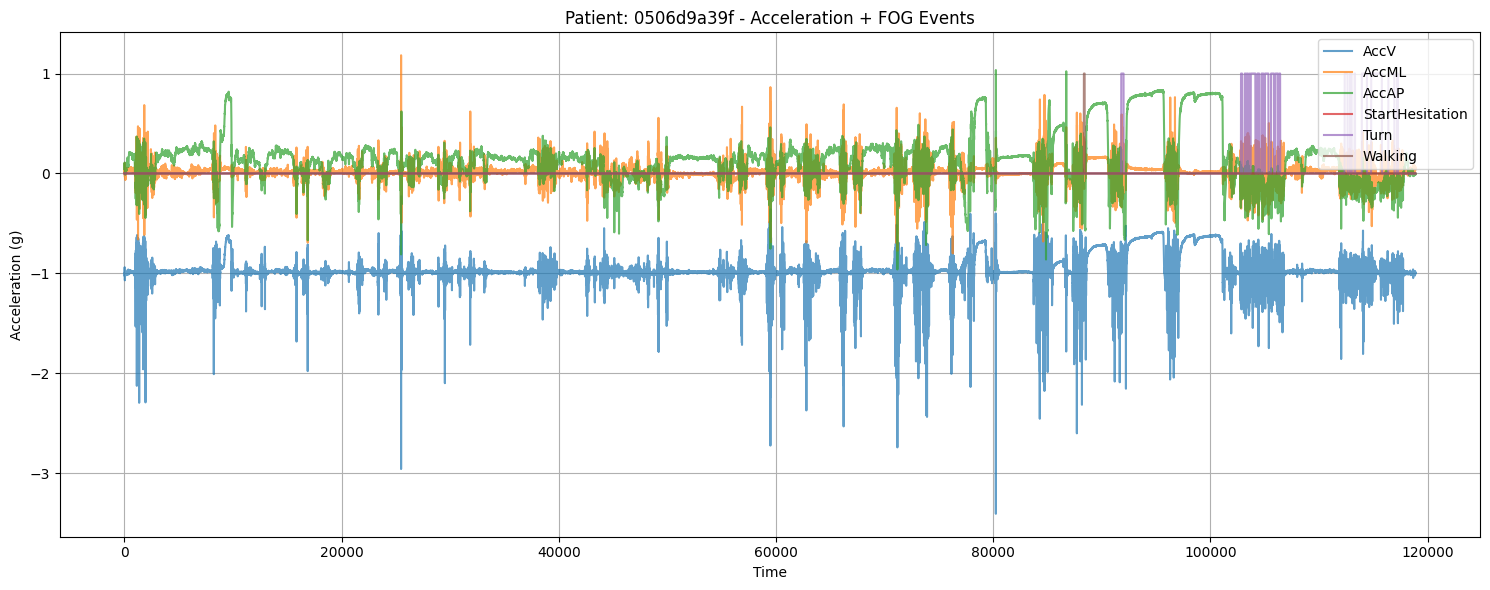

In [15]:
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == 'be9d33541d').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)
plt.plot(df['Time'], df['Turn'], label='Turn', alpha=0.7)
plt.plot(df['Time'], df['Walking'], label='Walking', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# plt.plot(notype_df['Time'], notype_df['AccV'])
# plt.title("AccV over Time")
# plt.xlabel("Time")
# plt.ylabel("AccV")

In [17]:
# plt.plot(df_tdcsfog['Time'], df_tdcsfog['AccV'])
# plt.title("AccV over Time")
# plt.xlabel("Time")
# plt.ylabel("AccV")

In [18]:
# plt.figure(figsize=(10, 6))
# sns.heatmap(df_defog.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Between Features and Task Labels')
# plt.show()

# Data Cleaning

Handle Missing Values
* Check missingness
* decide: drop columns or rows of too many missing values or impute (forward fill, backward fill, or interpolate)

Detect and correct erroneous values
* Spikes or dropouts in sensor readings
* Duplicated timestamps
* Values outside physical limits (e.g., g-force beyond ±16g if using IMUs)

Check for:
* Outliers: Z-score, IQR method
* Signal gaps
* Negative time values or duplicates

Normalize or standardize data using StandardScaler or MinMaxScaler

In [19]:
# Data types of features 
print(f'DEFOG DATA TYPES:\n{defog_df.dtypes}\n')
print(f'TDCSFOG DATA TYPES:\n{tdcsfog_df.dtypes}\n')
print(f'NOTYPE DATA TYPES:\n{notype_df.dtypes}\n')

DEFOG DATA TYPES:
[Int64, Float64, Float64, Float64, Int64, Int64, Int64, Boolean, Boolean, String]

TDCSFOG DATA TYPES:
[Int64, Float64, Float64, Float64, Int64, Int64, Int64, String]

NOTYPE DATA TYPES:
[Int64, Float64, Float64, Float64, Int64, Boolean, Boolean, String]



In [20]:
print(defog_df.null_count())
# missing_rows = defog_df[defog_df.isnull().any(axis=1)]
# print(missing_rows)


shape: (1, 10)
┌──────┬──────┬───────┬───────┬───┬─────────┬───────┬──────┬────────────┐
│ Time ┆ AccV ┆ AccML ┆ AccAP ┆ … ┆ Walking ┆ Valid ┆ Task ┆ patient_id │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆   ┆ ---     ┆ ---   ┆ ---  ┆ ---        │
│ u32  ┆ u32  ┆ u32   ┆ u32   ┆   ┆ u32     ┆ u32   ┆ u32  ┆ u32        │
╞══════╪══════╪═══════╪═══════╪═══╪═════════╪═══════╪══════╪════════════╡
│ 0    ┆ 0    ┆ 0     ┆ 0     ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ 0          │
└──────┴──────┴───────┴───────┴───┴─────────┴───────┴──────┴────────────┘


In [21]:
print(notype_df.null_count())
# print(notype_df.isnull().sum())
# missing_rows = notype_df[notype_df.isnull().any(axis=1)]
# print(missing_rows)

shape: (1, 8)
┌──────┬──────┬───────┬───────┬───────┬───────┬──────┬────────────┐
│ Time ┆ AccV ┆ AccML ┆ AccAP ┆ Event ┆ Valid ┆ Task ┆ patient_id │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---  ┆ ---        │
│ u32  ┆ u32  ┆ u32   ┆ u32   ┆ u32   ┆ u32   ┆ u32  ┆ u32        │
╞══════╪══════╪═══════╪═══════╪═══════╪═══════╪══════╪════════════╡
│ 0    ┆ 0    ┆ 0     ┆ 0     ┆ 0     ┆ 0     ┆ 0    ┆ 0          │
└──────┴──────┴───────┴───────┴───────┴───────┴──────┴────────────┘


In [22]:
print(tdcsfog_df.null_count())
# print(tdcsfog_df.isnull().sum())
# missing_rows = tdcsfog_df[tdcsfog_df.isnull().any(axis=1)]
# print(missing_rows)

shape: (1, 8)
┌──────┬──────┬───────┬───────┬─────────────────┬──────┬─────────┬────────────┐
│ Time ┆ AccV ┆ AccML ┆ AccAP ┆ StartHesitation ┆ Turn ┆ Walking ┆ patient_id │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆ ---             ┆ ---  ┆ ---     ┆ ---        │
│ u32  ┆ u32  ┆ u32   ┆ u32   ┆ u32             ┆ u32  ┆ u32     ┆ u32        │
╞══════╪══════╪═══════╪═══════╪═════════════════╪══════╪═════════╪════════════╡
│ 0    ┆ 0    ┆ 0     ┆ 0     ┆ 0               ┆ 0    ┆ 0       ┆ 0          │
└──────┴──────┴───────┴───────┴─────────────────┴──────┴─────────┴────────────┘


In [23]:
# Convert accerlations in defog and notype to m/s^2
G_CONVERSION = 9.80665
defog_df[["AccV", "AccML", "AccAP"]] *= G_CONVERSION
notype_df[["AccV", "AccML", "AccAP"]] *= G_CONVERSION
print(defog_df)
print(notype_df)

shape: (13_525_702, 10)
┌────────┬───────────┬──────────┬───────────┬───┬─────────┬───────┬───────┬────────────┐
│ Time   ┆ AccV      ┆ AccML    ┆ AccAP     ┆ … ┆ Walking ┆ Valid ┆ Task  ┆ patient_id │
│ ---    ┆ ---       ┆ ---      ┆ ---       ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---        │
│ i64    ┆ f64       ┆ f64      ┆ f64       ┆   ┆ i64     ┆ bool  ┆ bool  ┆ str        │
╞════════╪═══════════╪══════════╪═══════════╪═══╪═════════╪═══════╪═══════╪════════════╡
│ 0      ┆ -9.833101 ┆ 0.219382 ┆ 0.669832  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 1      ┆ -9.832554 ┆ 0.188024 ┆ 0.648829  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 2      ┆ -9.804885 ┆ 0.187721 ┆ 0.662298  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 3      ┆ -9.787264 ┆ 0.180227 ┆ 0.670866  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 4      ┆ -9.790555 ┆ 0.164025 ┆ 0.651633  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ …      ┆ …         ┆ …        ┆ …         ┆ … ┆ …       ┆ …     ┆ …     ┆ …         

In [24]:
# Convert the Valid and Task Columns to Integer Columns
def convert_valid_and_t(df):
    df = df.with_columns(
        pl.col("Valid").cast(pl.Int8).alias("Valid")
    )
    
    df = df.with_columns(
        pl.col("Task").cast(pl.Int8).alias("Task")
    )
    return df
defog_df = convert_valid_and_t(defog_df)
notype_df = convert_valid_and_t(notype_df)
# tdcsfog_df = convert_valid_and_t(tdcsfog_df)


print(defog_df)


shape: (13_525_702, 10)
┌────────┬───────────┬──────────┬───────────┬───┬─────────┬───────┬──────┬────────────┐
│ Time   ┆ AccV      ┆ AccML    ┆ AccAP     ┆ … ┆ Walking ┆ Valid ┆ Task ┆ patient_id │
│ ---    ┆ ---       ┆ ---      ┆ ---       ┆   ┆ ---     ┆ ---   ┆ ---  ┆ ---        │
│ i64    ┆ f64       ┆ f64      ┆ f64       ┆   ┆ i64     ┆ i8    ┆ i8   ┆ str        │
╞════════╪═══════════╪══════════╪═══════════╪═══╪═════════╪═══════╪══════╪════════════╡
│ 0      ┆ -9.833101 ┆ 0.219382 ┆ 0.669832  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 1      ┆ -9.832554 ┆ 0.188024 ┆ 0.648829  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 2      ┆ -9.804885 ┆ 0.187721 ┆ 0.662298  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 3      ┆ -9.787264 ┆ 0.180227 ┆ 0.670866  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 4      ┆ -9.790555 ┆ 0.164025 ┆ 0.651633  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ …      ┆ …         ┆ …        ┆ …         ┆ … ┆ …       ┆ …     ┆ …    ┆ …          │
│ 109120

In [25]:
# Create a new column that contains the acceleration magnitude
def acc_magnitude(df):
    df = df.with_columns(
        (
            (pl.col("AccV") ** 2 + pl.col("AccML") ** 2 + pl.col("AccAP") ** 2).sqrt()
        ).alias("Acc_MAGNITUDE")
    )

    return df

tdcsfog_df = acc_magnitude(tdcsfog_df)
defog_df = acc_magnitude(tdcsfog_df)
notype_df = acc_magnitude(notype_df)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,patient_id,Acc_MAGNITUDE
i64,f64,f64,f64,i64,i64,i64,str,f64
0,-9.66589,0.04255,0.184744,0,0,0,"""a171e61840""",9.667749
1,-9.672969,0.049217,0.184644,0,0,0,"""a171e61840""",9.674856
2,-9.67026,0.03362,0.19379,0,0,0,"""a171e61840""",9.67226
3,-9.673356,0.035159,0.184369,0,0,0,"""a171e61840""",9.675176
4,-9.671458,0.043913,0.197814,0,0,0,"""a171e61840""",9.67358
…,…,…,…,…,…,…,…,…
5153,-9.91592,-0.105897,-1.123455,0,0,0,"""0506d9a39f""",9.979921
5154,-9.693752,-0.066892,-1.114903,0,0,0,"""0506d9a39f""",9.757885
5155,-9.548118,-0.098315,-1.112123,0,0,0,"""0506d9a39f""",9.61317


In [26]:
def outlier_acc_magnitude(df):
    df_outlier = df.with_columns(
        (pl.col('Acc_MAGNITUDE') > 30).alias('is_outlier_mag')
    )
    filtered_df = df_outlier.filter(pl.col("is_outlier_mag") == "True")
    return filtered_df
print(outlier_acc_magnitude(defog_df))
print(outlier_acc_magnitude(tdcsfog_df))
print(outlier_acc_magnitude(notype_df))



shape: (0, 10)
┌──────┬──────┬───────┬───────┬───┬─────────┬────────────┬───────────────┬────────────────┐
│ Time ┆ AccV ┆ AccML ┆ AccAP ┆ … ┆ Walking ┆ patient_id ┆ Acc_MAGNITUDE ┆ is_outlier_mag │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆   ┆ ---     ┆ ---        ┆ ---           ┆ ---            │
│ i64  ┆ f64  ┆ f64   ┆ f64   ┆   ┆ i64     ┆ str        ┆ f64           ┆ bool           │
╞══════╪══════╪═══════╪═══════╪═══╪═════════╪════════════╪═══════════════╪════════════════╡
└──────┴──────┴───────┴───────┴───┴─────────┴────────────┴───────────────┴────────────────┘
shape: (0, 10)
┌──────┬──────┬───────┬───────┬───┬─────────┬────────────┬───────────────┬────────────────┐
│ Time ┆ AccV ┆ AccML ┆ AccAP ┆ … ┆ Walking ┆ patient_id ┆ Acc_MAGNITUDE ┆ is_outlier_mag │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆   ┆ ---     ┆ ---        ┆ ---           ┆ ---            │
│ i64  ┆ f64  ┆ f64   ┆ f64   ┆   ┆ i64     ┆ str        ┆ f64           ┆ bool           │
╞══════╪══════╪═══════╪═══════╪═══╪═════════╪═════

In [27]:
# Standardize acceleration per patient for each training dataframe
def standardize_acc_by_patient(df: pl.DataFrame):
    acc_cols = ['AccV', 'AccML', 'AccAP']
    for col in acc_cols:
        df = df.with_columns(
            (
                (pl.col(col) - pl.col(col).mean().over("patient_id")) /
                pl.col(col).std().over("patient_id")
            ).alias(col)  # overwrite original column
        )
    return df

tdcsfog_df = standardize_acc_by_patient(tdcsfog_df)
defog_df = standardize_acc_by_patient(defog_df)
notype_df = standardize_acc_by_patient(notype_df)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,patient_id,Acc_MAGNITUDE
i64,f64,f64,f64,i64,i64,i64,str,f64
0,-0.083911,0.203213,-0.67943,0,0,0,"""a171e61840""",9.667749
1,-0.089146,0.208098,-0.679487,0,0,0,"""a171e61840""",9.674856
2,-0.087143,0.196669,-0.674231,0,0,0,"""a171e61840""",9.67226
3,-0.089432,0.197797,-0.679645,0,0,0,"""a171e61840""",9.675176
4,-0.088028,0.204211,-0.671919,0,0,0,"""a171e61840""",9.67358
…,…,…,…,…,…,…,…,…
5153,-0.463118,0.20755,-1.838585,0,0,0,"""0506d9a39f""",9.979921
5154,-0.305387,0.236566,-1.834007,0,0,0,"""0506d9a39f""",9.757885
5155,-0.201991,0.21319,-1.832518,0,0,0,"""0506d9a39f""",9.61317


In [28]:
# Create a new column that contains Time as seconds
def time_to_seconds(df, hertz):
    df = df.with_columns(
        (
            (pl.col("Time") / hertz)
        ).alias("Time (seconds)")
    )

    return df

tdcsfog_df = time_to_seconds(tdcsfog_df, 128)
defog_df = time_to_seconds(tdcsfog_df, 100)
notype_df = time_to_seconds(notype_df, 100)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,patient_id,Acc_MAGNITUDE,Time (seconds)
i64,f64,f64,f64,i64,i64,i64,str,f64,f64
0,-0.083911,0.203213,-0.67943,0,0,0,"""a171e61840""",9.667749,0.0
1,-0.089146,0.208098,-0.679487,0,0,0,"""a171e61840""",9.674856,0.01
2,-0.087143,0.196669,-0.674231,0,0,0,"""a171e61840""",9.67226,0.02
3,-0.089432,0.197797,-0.679645,0,0,0,"""a171e61840""",9.675176,0.03
4,-0.088028,0.204211,-0.671919,0,0,0,"""a171e61840""",9.67358,0.04
…,…,…,…,…,…,…,…,…,…
5153,-0.463118,0.20755,-1.838585,0,0,0,"""0506d9a39f""",9.979921,51.53
5154,-0.305387,0.236566,-1.834007,0,0,0,"""0506d9a39f""",9.757885,51.54
5155,-0.201991,0.21319,-1.832518,0,0,0,"""0506d9a39f""",9.61317,51.55


In [29]:
# Check for outliers from acceleration
def detect_outliers(df: pl.DataFrame):
    acc_cols = ['AccV', 'AccML', 'AccAP']
    for col in acc_cols: 
        z_col = col
        outlier_df = df.filter(pl.col(z_col).abs() > 3.0)
    return outlier_df
print(detect_outliers(defog_df))
print(detect_outliers(tdcsfog_df))
print(detect_outliers(notype_df))

# def detect_outliers(df):
#     acc_cols = ['AccV', 'AccML', 'AccAP']
#     subject_ids_with_outliers = set()

#     for col in acc_cols:
#         z_col = col  # Assuming the column already holds standardized z-scores

#         # Detect rows where z-score > threshold
#         outlier_df = df.filter(pl.col(z_col).abs() > 3.0)

#         # Collect unique subject IDs with outliers
#         if 'patient_id' in df.columns:
#             outlier_subjects = outlier_df.select('patient_id').unique()
#             subject_ids_with_outliers.update(outlier_subjects['patient_id'].to_list())
#         elif 'subject_id' in df.columns:
#             outlier_subjects = outlier_df.select('subject_id').unique()
#             subject_ids_with_outliers.update(outlier_subjects['subject_id'].to_list())
#         else:
#             raise ValueError("Missing 'patient_id' or 'subject_id' column in DataFrame.")

#     return list(subject_ids_with_outliers)

# tdcsfog_outlier_subjects = detect_outliers(tdcsfog_df)
# defog_outlier_subjects = detect_outliers(defog_df)
# notype_outlier_subjects = detect_outliers(notype_df)

# print("Subjects with outliers in tdcsfog:", tdcsfog_outlier_subjects)
# print("Subjects with outliers in defog:", defog_outlier_subjects)
# print("Subjects with outliers in notype:", notype_outlier_subjects)



shape: (92_179, 10)
┌──────┬───────────┬───────────┬───────────┬───┬─────────┬────────────┬──────────────┬─────────────┐
│ Time ┆ AccV      ┆ AccML     ┆ AccAP     ┆ … ┆ Walking ┆ patient_id ┆ Acc_MAGNITUD ┆ Time        │
│ ---  ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---     ┆ ---        ┆ E            ┆ (seconds)   │
│ i64  ┆ f64       ┆ f64       ┆ f64       ┆   ┆ i64     ┆ str        ┆ ---          ┆ ---         │
│      ┆           ┆           ┆           ┆   ┆         ┆            ┆ f64          ┆ f64         │
╞══════╪═══════════╪═══════════╪═══════════╪═══╪═════════╪════════════╪══════════════╪═════════════╡
│ 1910 ┆ -1.290404 ┆ 1.618016  ┆ 3.612224  ┆ … ┆ 0       ┆ a171e61840 ┆ 13.787228    ┆ 19.1        │
│ 1911 ┆ -2.917139 ┆ 2.923083  ┆ 3.496609  ┆ … ┆ 0       ┆ a171e61840 ┆ 15.868035    ┆ 19.11       │
│ 1924 ┆ -2.735014 ┆ 0.30849   ┆ -3.010618 ┆ … ┆ 0       ┆ a171e61840 ┆ 13.806283    ┆ 19.24       │
│ 1925 ┆ -3.089478 ┆ 0.467506  ┆ -3.192343 ┆ … ┆ 0       ┆ a171e61840 ┆